# Financial Fraud Detection


PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

About the columns: 
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
## Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA

In [2]:
## Importing Dataset

df = pd.read_csv("C:/Users/dell/Desktop/PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Basic EDA

In [3]:
df.shape

(6362620, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
df['step'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

We are interested in knowing weather or not fradulent occur during the type of the transaction made. So let's observe the isfraud variable and see the distribution.

In [8]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
## Representing in ratio



We can clearly see that among more than 6 million transaction made only around 8000 transactions are said to be fradulent. This is the case of <b>Imbalance dataset</b>. This condition must be handled because if this condition is not handled then we are definately going to get a biased model which might wrongly predict our data and might show non-fradulent case in the fradulent case.

<AxesSubplot:xlabel='isFraud', ylabel='count'>

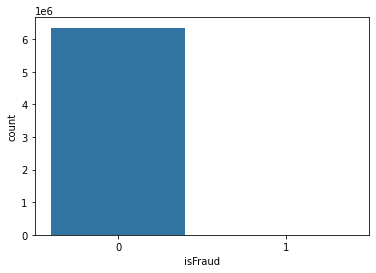

In [10]:
## let's plot a countplot

sns.countplot(x='isFraud',data = df)

In [11]:
## Let's find out about the discrete and continuous values in ourdatasets

# list of numerical variables
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))
print('The name of the numerical variables are: ', (numerical_features))

Number of numerical variables:  8
The name of the numerical variables are:  ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [12]:
# List of continuous variables

continuous_feature = [feature for feature in numerical_features if len(df[feature].unique()) > 25]
print(len(continuous_feature))
print(continuous_feature)

6
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


If any numerical column has unique count of values more than 25 then we consider varible in such columns as continuous variable or data.

In [13]:
## List of dicrete variable



discrete_feature = [feature for feature in numerical_features if len(df[feature].unique()) < 25]
print(discrete_feature)


['isFraud', 'isFlaggedFraud']


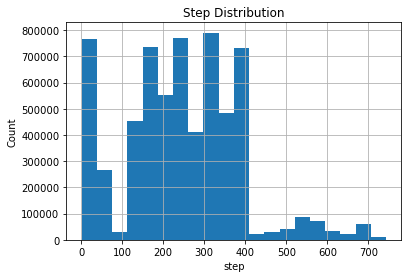

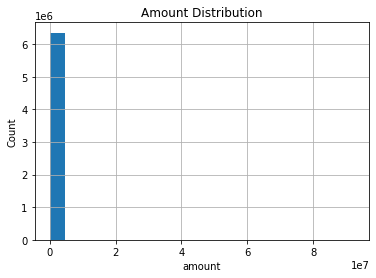

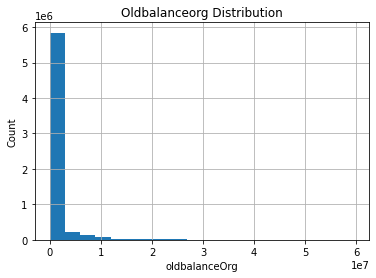

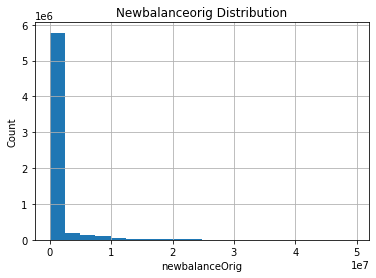

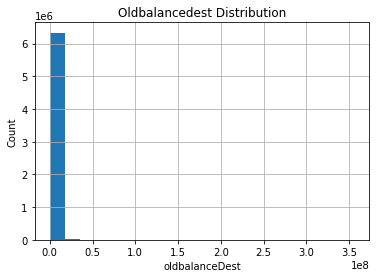

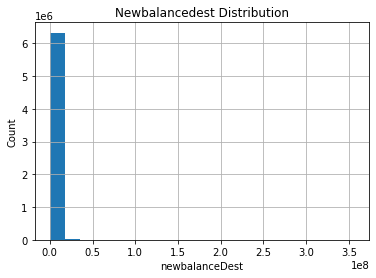

In [14]:
## Now let's see the distribution of each of our continuous columns

for feature in continuous_feature:
  data = df.copy()
  data[feature].hist(bins = 20)
  plt.xlabel(feature)
  plt.ylabel("Count")
  plt.title(feature.title()+" " + "Distribution")
  plt.show()

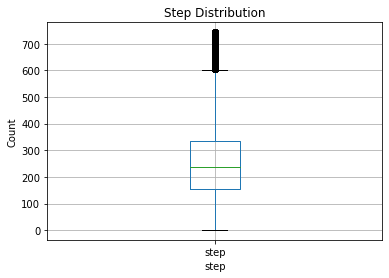

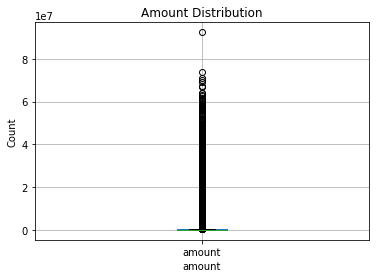

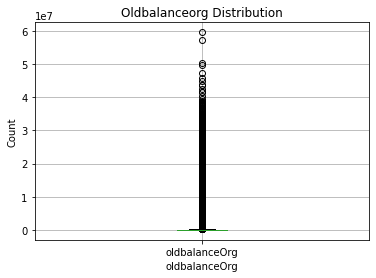

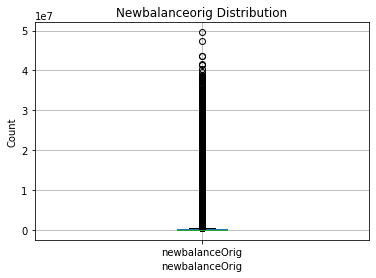

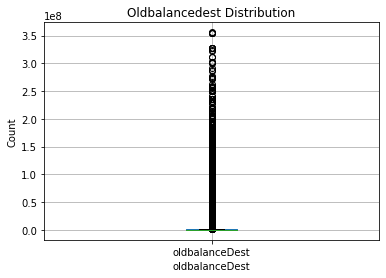

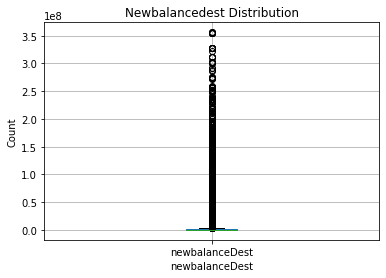

In [15]:
## Let's detect some outliers and we will remove it if we need to in coming future


for feature in continuous_feature:
  data = df.copy()
  data.boxplot(column = feature)
  plt.xlabel(feature)
  plt.ylabel("Count")
  plt.title(feature.title()+" " + "Distribution")
  plt.show()

There seems to be a lot of outliers in the amount section but this is something we cannot avoid or we shouldn't avoid. Because definately different people are going to have different amount in the bank account(some might have low ammount,some might have relatively higher amount) due to which we shouldn't remove such outlier. If we try to remove those outliers then it will possibly result in creation of faulty model.

In [16]:
## Another interesting variable is the type varible let's study about that variable

df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [17]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

<AxesSubplot:xlabel='type', ylabel='count'>

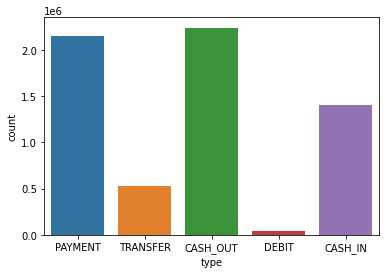

In [18]:
sns.countplot(x = 'type',data = df)

In [19]:
print('Type of payments which are fraudulent are:',list(df.loc[(df.isFraud==1)].type.unique()))
print('No. of fraudulent transfers which are "Transfer" type are :', len(df.loc[(df.isFraud==1)&(df.type=='TRANSFER')]))
print('No. of fraudulent transfers which are "CASH_OUT" type are :', len(df.loc[(df.isFraud==1)&(df.type=='CASH_OUT')]))

Type of payments which are fraudulent are: ['TRANSFER', 'CASH_OUT']
No. of fraudulent transfers which are "Transfer" type are : 4097
No. of fraudulent transfers which are "CASH_OUT" type are : 4116


In our dataset the two columns oldbalanceDest and newbalanceDest don't have the value for customers with M let's decode this situation.

In [20]:
## Let's find out how many customers holding the orginal account and destination account are merchants M

len(df.loc[df['nameOrig'].str.contains('M') == True])

0

In [21]:
len(df.loc[df['nameDest'].str.contains('M') == True])

2151495

In [22]:
df.loc[df['type']=='TRANSFER'].nameDest.str.contains('M').any()

False

In [23]:
df.loc[df['type']=='CASH_OUT'].nameDest.str.contains('M').any()

False

This analysis shows that there hasn't been any kind of cash_out, and transfer transaction in the merchant account so they are free from frauds.

In [24]:
## Splitting the datasets into training and testing

## Data cleaning and Feature Engineering


<AxesSubplot:>

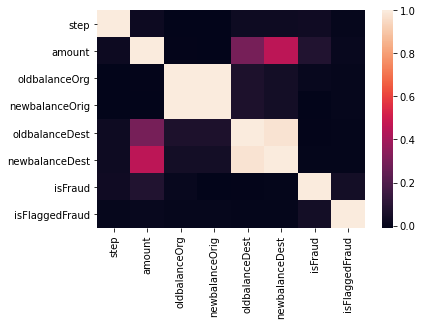

In [25]:
sns.heatmap(df.corr())

We can remove the feature like isFlagged,nameDest and nameOrig.

In [26]:
data1 = df.loc[(df.type=='TRANSFER')|(df.type=='CASH_OUT')]

In [27]:
data1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [28]:
data1.shape

(2770409, 11)

In [29]:
data1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


So we have created a dataset that contains the records of the rows whose type is either Transfer or cash_out so that we can easily transform the dataset.

In [30]:
data1.drop(["nameOrig", "nameDest","isFlaggedFraud"],axis = 1, inplace = True)

C:\Users\dell\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
data1.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


### Encoding 'type' column

In [32]:
from sklearn.preprocessing import LabelEncoder

In [33]:
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
data1['Type'] = labelencoder.fit_transform(data1['type'])


<ipython-input-33-f942d2f5b1b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Type'] = labelencoder.fit_transform(data1['type'])


In [34]:
data1.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Type
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,1
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


So we have :
Transfer - 1
CASH_OUT - 0

In [35]:
data1.drop(['type'],axis =1,inplace = True)

C:\Users\dell\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
data1.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Type
2,1,181.00,181.0,0.0,0.0,0.00,1,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


In [37]:
## Feature selection

X = data1.drop('isFraud',axis = 1)
y = data1['isFraud']

## Creating a train_test split

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.3,random_state= 42)

In [40]:
X_train.shape,y_train.shape

((1939286, 7), (1939286,))

## DataScaling 

In [41]:
from sklearn.preprocessing import StandardScaler

In [42]:
scale = StandardScaler()

X_train_std = scale.fit_transform(X_train)
X_test_std = scale.transform(X_test)


In [43]:
X_train_std.shape,X_test_std.shape

((1939286, 7), (831123, 7))

### Building a preliminary model without data balancing

### We will firstly use Random Forest

In [55]:
from sklearn.metrics import average_precision_score,accuracy_score,f1_score,classification_report,precision_recall_curve,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [45]:
random_forest = RandomForestClassifier()

In [46]:
random_forest.fit(X_train_std,y_train)

RandomForestClassifier()

In [47]:
y_prob = random_forest.predict_proba(X_test_std)[:,1]
y_pred = np.where(y_prob > 0.5,1,0)

random_forest.score(X_test_std,y_pred)

1.0

In [48]:
prediction = random_forest.predict(X_test_std)

In [49]:
accuracy_score(y_test,prediction)

0.9992708660450981

Wait for the real climax.

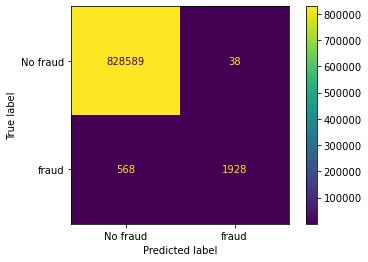

In [50]:
plot_confusion_matrix(random_forest,X_test_std,y_test,values_format = 'd',display_labels= ["No fraud","fraud"])

We have a lot of false Negative value as well as false positive value which can be very dangerous to us. Let's see other metrics to better analyze the problem in the dataset.

In [57]:
def model_result(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print('F1 - score :',(f1_score(y_test,y_pred)))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test,y_pred))
    print("accuracy_score")
    print(accuracy_score(y_test,y_pred))
    print("classification_report")
    print(classification_report(y_test,y_pred))

In [58]:
model_result(random_forest,X_train_std,y_train)

AUPRC : 1.0
F1 - score : 0.9999125338931164
Confusion_matrix : 
[[1933569       0]
 [      1    5716]]
accuracy_score
0.9999994843463006
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1933569
           1       1.00      1.00      1.00      5717

    accuracy                           1.00   1939286
   macro avg       1.00      1.00      1.00   1939286
weighted avg       1.00      1.00      1.00   1939286



In [59]:
model_result(random_forest,X_test_std,y_test)

AUPRC : 0.9379207580480804
F1 - score : 0.8641864634692963
Confusion_matrix : 
[[828589     38]
 [   568   1928]]
accuracy_score
0.9992708660450981
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828627
           1       0.98      0.77      0.86      2496

    accuracy                           1.00    831123
   macro avg       0.99      0.89      0.93    831123
weighted avg       1.00      1.00      1.00    831123



In [60]:
## Using ROC-AUC
from sklearn import metrics

auc_roc = metrics.roc_auc_score(y_test,y_pred)
auc_roc

0.8861950192213235

In [61]:
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, y_prob, pos_label=1)

In [62]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [63]:
auc_roc = metrics.roc_auc_score(y_test,y_prob)
auc_roc

0.9933500018841022

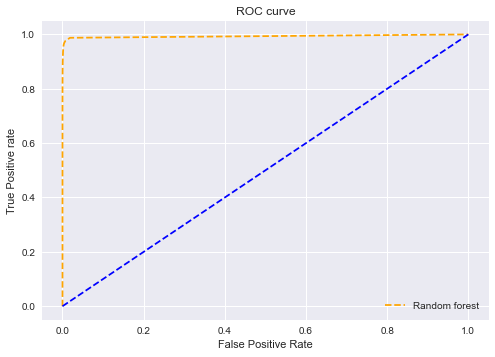

In [64]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random forest')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### Even though we have fairly good f1 score but still we have huge number of false negative and false positive which can be very harmful in the case of fradulent case so, we will apply couple of steps to improve our result.



## Using class_weight for the imbalance datasets

In [65]:
random_forest_wcw = RandomForestClassifier(class_weight='balanced')
random_forest_wcw.fit(X_train_std,y_train)

RandomForestClassifier(class_weight='balanced')

In [66]:
## Predicting on test data

prediction1 = random_forest_wcw.predict(X_test_std)

In [67]:
## Accuracy score

accuracy_score(y_test,prediction1)

0.9992636468970297

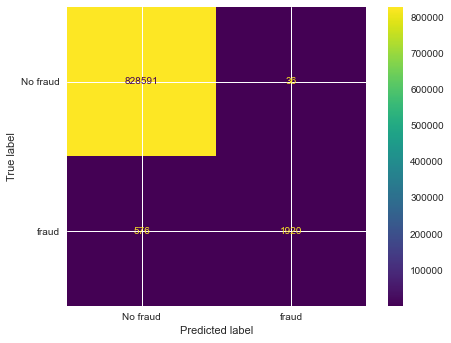

In [68]:
plot_confusion_matrix(random_forest_wcw,X_test_std,y_test,values_format = 'd',display_labels= ["No fraud","fraud"])

We can see that using the class_weight balance we actually increased the value of the false negative.

In [69]:
## Let's study the performance metrics

model_result(random_forest_wcw,X_test_std,y_test)

AUPRC : 0.9393583166332111
F1 - score : 0.862533692722372
Confusion_matrix : 
[[828591     36]
 [   576   1920]]
accuracy_score
0.9992636468970297
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828627
           1       0.98      0.77      0.86      2496

    accuracy                           1.00    831123
   macro avg       0.99      0.88      0.93    831123
weighted avg       1.00      1.00      1.00    831123



Definately no improvement in f1 score.

### Let's try with the manual weights.

In [ ]:
0 (w1) : 0.5006
1 (w2) : 387.350

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
random_forest = RandomForestClassifier()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= random_forest, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_std, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


### We will now use Support Vector Machines

In [ ]:

from sklearn.svm import SVC


In [ ]:
## Using linear kernel

svclassifier = SVC(kernel='linear',random_state=42)
svclassifier.fit(X_train_std,y_train)

In [ ]:
y_pred = svclassifier.predict(X_test_std)

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
plot_confusion_matrix(svclassifier,X_test_std,y_test,values_format = 'd',display_labels= ["No fraud","fraud"])

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

## 1st Method: Machine learning with SMOTE for imbalance dataset

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state = 42)

X_sm,y_sm = sm.fit_resample(X,y)

X.shape,X_sm.shape

In [ ]:
## Let's split

X_sm_train,X_sm_test,y_sm_train,y_sm_test = train_test_split(X_sm,y_sm,test_size= 0.3,random_state= 42)

In [ ]:
scale1 = StandardScaler()

X_sm_train_std = scale1.fit_transform(X_sm_train)
X_test_sm_std = scale1.transform(X_sm_test)


In [ ]:
model = RandomForestClassifier()


In [ ]:
model.fit(X_sm_train_std,y_sm_train)

In [ ]:
predicti = model.predict(X_test_sm_std)

In [ ]:
accuracy_score(y_sm_test,predicti)

In [ ]:
plot_confusion_matrix(model,X_test_sm_std,y_sm_test,values_format = 'd',display_labels= ["No fraud","fraud"])

In [ ]:
model_result(model,X_sm_train_std,y_sm_train)

In [ ]:
model_result(model,X_test_sm_std,y_sm_test)